In [1]:
import cv2, os
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,10]

In [2]:
OUTPUT_PATH = "max_around/grabcut_sqaure"
INPUT_PATH = "D:\\Datasets\\max_around\\%03d%03d.png"
THESHOLD_RATIO = 25.0 / 255.0
BACKGROUND_COLOR = np.floor(np.array([0.183303607917275, 0.184864718048662, 0.182593791333333]) * 255.0)
TOTAL_CAMERA = 10
TOTAL_IMAGE_PER_CAMERA = 40
GRABCUT_ITERATION = 2
MP_POOL_SIZE = 10

In [3]:
CAMERA_NUMBER, current_shot = (0,1)
previous_shot = (current_shot - 1) % TOTAL_IMAGE_PER_CAMERA

In [4]:
# read image
image_prev_uint = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,previous_shot)) 
image_current_uint = cv2.imread(INPUT_PATH % (CAMERA_NUMBER,current_shot)) 
# convert to RGB
image_prev_uint = cv2.cvtColor(image_prev_uint,cv2.COLOR_BGR2RGB)
image_current_uint = cv2.cvtColor(image_current_uint,cv2.COLOR_BGR2RGB)
# rotate
image_prev_uint = cv2.rotate(image_prev_uint, cv2.ROTATE_90_CLOCKWISE)
image_current_uint = cv2.rotate(image_current_uint, cv2.ROTATE_90_CLOCKWISE)
# convert to [0-1]
image_prev =  image_prev_uint / 255.0
image_current = image_current_uint / 255.0

In [5]:
# difference mask between 2 images
diff_mask = np.linalg.norm(image_current - image_prev, axis=-1, keepdims=True)
diff_mask = (diff_mask > THESHOLD_RATIO) * 1.0
diff_mask = diff_mask[:,:,0]

In [6]:
# remove artifact by opening 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
diff_mask_opened = cv2.morphologyEx(diff_mask, cv2.MORPH_OPEN, kernel)

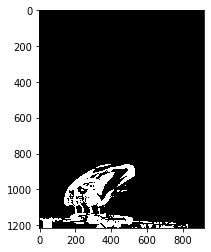

In [25]:
plt.imshow(diff_mask_opened,cmap='gray')

In [7]:
#reduce size by erosion
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
sure_foreground = cv2.erode(diff_mask_opened, kernel)

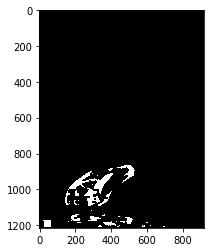

In [8]:
plt.imshow(sure_foreground,cmap='gray')

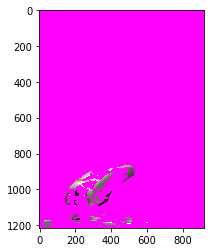

In [9]:
output = image_current_uint.copy()
output[sure_foreground == 0] = (255, 0, 255)
plt.imshow(output)

In [11]:
# find boundary (rectangle) of object 
mask_y, mask_x = np.nonzero(diff_mask_opened)
min_x = np.min(mask_x)
max_x = np.max(mask_x)
min_y = np.min(mask_y)
max_y = np.max(mask_y)

In [12]:
sure_background = np.zeros(diff_mask_opened.shape)
for i in range(sure_background.shape[0]):
    for j in range(sure_background.shape[1]):
        if i >= min_y and i <= max_y and j >= min_x and j <= max_x:
            pass
        else:
            sure_background[i][j] = 1

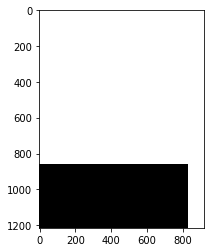

In [13]:
plt.imshow(sure_background,cmap='gray')

In [14]:
def whiten(im):
    H, W, C = im.shape
    # Flatten
    whitened_im = im.reshape(-1, C).astype('float')
    # Whiten the feature
    whitened_im -= np.mean(whitened_im, 0)
    whitened_im /= np.sqrt(np.mean(whitened_im ** 2, 0))
    return whitened_im.reshape(H, W, C)

In [15]:
# Create a grid CRF
N_LABEL = 2
MAX_ITER = 200

feat = whiten(image_current_uint)
H, W, _ = image_current_uint.shape

In [16]:
def rbf_kernel(dist, sigma=3):
    return np.exp(- np.sum(dist ** 2, 2) / sigma)

In [17]:
# Create pairwise conditional probability with nearest 4 neighbors
curr_feat = feat[1:H - 1, 1:W - 1]
top, bottom, left, right = np.zeros((H, W)), np.zeros(
    (H, W)), np.zeros((H, W)), np.zeros((H, W))

compatibility = np.array([[-2, 0], [0, -2]])
top[1:H - 1,    1:W - 1] = rbf_kernel(curr_feat - feat[0:H - 2, 1:W - 1])
bottom[1:H - 1, 1:W - 1] = rbf_kernel(curr_feat - feat[2:H,     1:W - 1])
left[1:H - 1,   1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 0:W - 2])
right[1:H - 1,  1:W - 1] = rbf_kernel(curr_feat - feat[1:H - 1, 2:W])

In [18]:
# Create unary potential
logit = np.zeros((H, W, N_LABEL))
unary = np.zeros((H, W, N_LABEL))

In [19]:
# Set probabilities
logit[:] = -1

In [20]:
# Set unary potential
unary[sure_background == 1] = [0, -3]
unary[sure_foreground == 1] = [-3, 0]

In [21]:
for curr_iter in range(MAX_ITER):

    score = np.exp(logit)
    prob = score / (np.sum(score, 2, keepdims=True) + 1e-6)
    
    # Pass message
    logit[1:H - 1, 1:W - 1] = (
        left[  1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 0:W - 2] +
        right[ 1:H - 1, 1:W - 1, np.newaxis] * prob[1:H - 1, 2:W] +
        top[   1:H - 1, 1:W - 1, np.newaxis] * prob[0:H - 2, 1:W - 1] +
        bottom[1:H - 1, 1:W - 1, np.newaxis] * prob[2:H,     1:W - 1]
    ).dot(compatibility) + unary[1:H - 1, 1:W - 1]

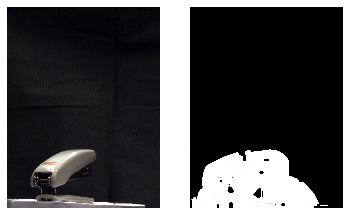

In [22]:
z = np.exp(logit[1:H - 1, 1:W - 1])
p = z / np.sum(z, 2, keepdims=True)
plt.subplot(1, 2, 1)
plt.imshow(image_current_uint)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(p[..., 0],cmap='gray')
plt.axis('off')
plt.show()

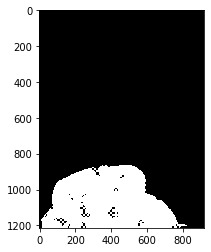

In [23]:
plt.imshow(np.around(p[..., 0]),cmap='gray')

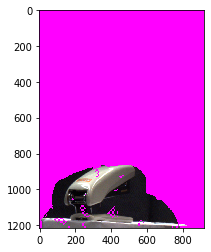

In [24]:
mask = p[..., 0]
output = image_current_uint.copy()
m_h, m_w = output.shape[:2]
mask = cv2.resize(mask, (m_w,m_h))
mask = np.around(mask)
output[mask == 0] = (255, 0, 255)
plt.imshow(output)